# Michelin Restaurants - case study
### Link, referring to dataset - https://www.kaggle.com/datasets/jackywang529/michelin-restaurants

## Goals of the analysis:
- Build model(s), that can accurately predict amount of stars, that restaurant will attain, based on new data
- Figure out, what factors will influence amount of stars, attained by restaurant

### Libraries importing

In [329]:
# Importing
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.svm import SVC

### Data importing

In [330]:
data1 = pd.read_csv("data/one-star-michelin-restaurants.csv")
data2 = pd.read_csv("data/two-stars-michelin-restaurants.csv")
data3 = pd.read_csv("data/three-stars-michelin-restaurants.csv")
data1['Stars'] = 1
data2['Stars'] = 2
data3['Stars'] = 3
#merging data in 1 Data Frame
restaurants = pd.concat([data1, data2, data3])
restaurants.drop(['zipCode', 'url'], axis=1, inplace=True)
price_mapping = {'$': 1, '$$':2,  '$$$':3, '$$$$':4, '$$$$$':5}
restaurants['price'] = restaurants['price'].map(price_mapping)


## Quick EDA: Part 1 - descriptive

In [331]:
print(restaurants.shape)
print(restaurants.info())
print(restaurants.describe(include="all"))
print(restaurants.isna().sum())


(695, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 0 to 35
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       695 non-null    object 
 1   year       695 non-null    int64  
 2   latitude   695 non-null    float64
 3   longitude  695 non-null    float64
 4   city       693 non-null    object 
 5   region     695 non-null    object 
 6   cuisine    695 non-null    object 
 7   price      519 non-null    float64
 8   Stars      695 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 54.3+ KB
None
                              name         year    latitude   longitude  \
count                          695   695.000000  695.000000  695.000000   
unique                         684          NaN         NaN         NaN   
top     L'Atelier de Joël Robuchon          NaN         NaN         NaN   
freq                             3          NaN         NaN         NaN   
mean      

In [332]:
print(restaurants.head(5))

            name  year   latitude  longitude            city   region  \
0   Kilian Stuba  2019  47.348580   10.17114  Kleinwalsertal  Austria   
1  Pfefferschiff  2019  47.837870   13.07917        Hallwang  Austria   
2      Esszimmer  2019  47.806850   13.03409        Salzburg  Austria   
3     Carpe Diem  2019  47.800010   13.04006        Salzburg  Austria   
4         Edvard  2019  48.216503   16.36852            Wien  Austria   

           cuisine  price  Stars  
0         Creative    5.0      1  
1  Classic cuisine    5.0      1  
2         Creative    5.0      1  
3   Market cuisine    5.0      1  
4   Modern cuisine    4.0      1  


## Quick EDA: Part 2 - visualization of some predictors

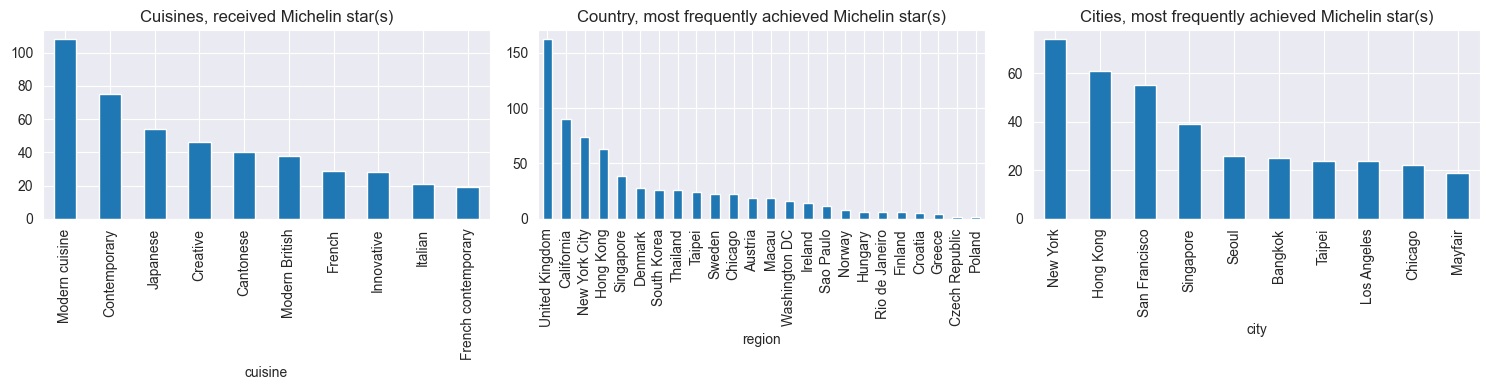

In [333]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
restaurants['cuisine'].value_counts().head(10).plot(kind='bar', ax=axes[0])
axes[0].set_title('Cuisines, received Michelin star(s)')

restaurants['region'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Country, most frequently achieved Michelin star(s)')

restaurants['city'].value_counts().head(10).plot(kind='bar', ax=axes[2])
axes[2].set_title('Cities, most frequently achieved Michelin star(s)')

plt.tight_layout()
plt.show()

### Target variable distribution - Amount of stars received


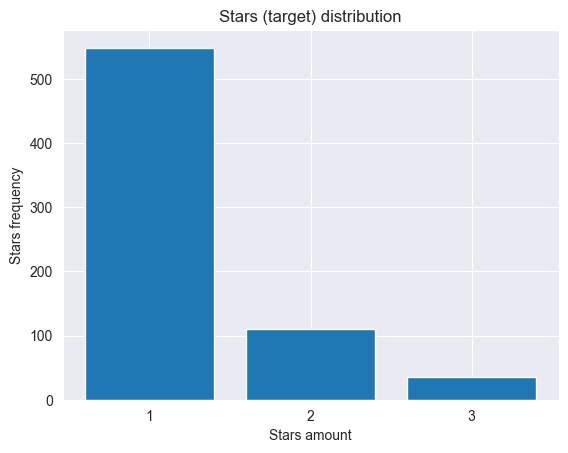

In [334]:
plt.bar(restaurants['Stars'].value_counts().index, restaurants['Stars'].value_counts())
plt.xlabel('Stars amount')
plt.xticks([1,2,3])
plt.ylabel('Stars frequency')
plt.title('Stars (target) distribution')

plt.show()

### The dataset is imbalanced due to a significant disparity in the number of observations between categories, as we can see from the bar plot above, so resampling will be needed.

## Preprocessing of data: conversion to categorical variables

In [335]:
restaurants.dropna(subset=['city'],inplace=True)

In [336]:
city_mapping = dict(enumerate(restaurants['city'].astype("category").cat.categories))
region_mapping = dict(enumerate(restaurants['region'].astype("category").cat.categories))
cuisine_mapping = dict(enumerate(restaurants['cuisine'].astype("category").cat.categories))
restaurants['city'] = restaurants['city'].astype("category").cat.codes
restaurants['region'] = restaurants['region'].astype("category").cat.codes
restaurants['cuisine'] = restaurants['cuisine'].astype("category").cat.codes
restaurants['Stars'] = restaurants['Stars'].astype("category")

### Variables 'city', 'region', 'cuisine', 'Stars' were encoded as categorical variables
### 2 observations, where 'city' == NA were dropped from dataset

In [337]:
restaurants.isna().sum()

name           0
year           0
latitude       0
longitude      0
city           0
region         0
cuisine        0
price        176
Stars          0
dtype: int64

#### Initial distribution of 'price' variable

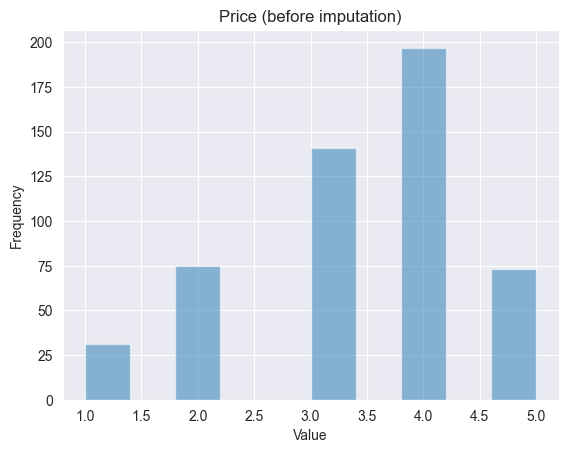

In [338]:
regression_datatest = restaurants.copy()
plt.hist(restaurants['price'], bins=10, alpha=0.5, label='Variable 1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Price (before imputation)')
plt.show()

### NA handling methods: Median imputation

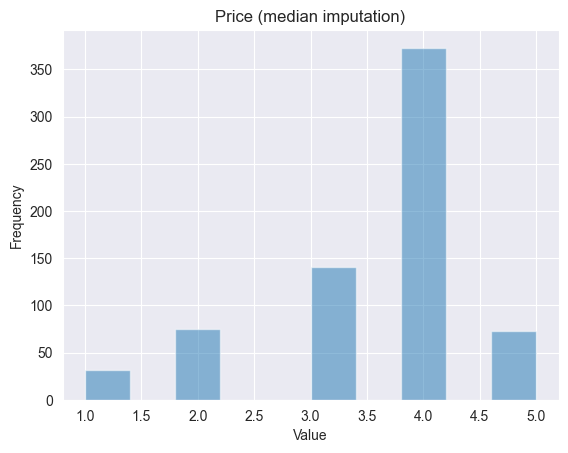

In [339]:
price_median_test = restaurants['price'].copy()
price_median_test.fillna(price_median_test.median(), inplace=True)

plt.hist(price_median_test, bins=10, alpha=0.5, label='Price')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Price (median imputation)')
plt.show()

### NA handling methods: Mean imputation

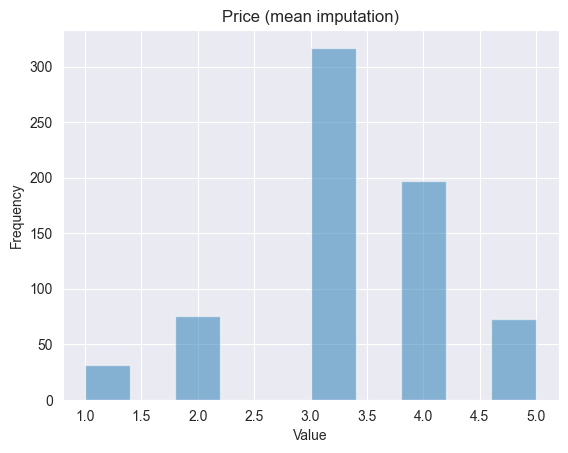

In [340]:
restaurants['price'].fillna(restaurants['price'].mean(), inplace=True)

plt.hist(restaurants['price'], bins=10, alpha=0.5, label='Price')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Price (mean imputation)')
plt.show()

In [341]:
restaurants.isna().sum()

name         0
year         0
latitude     0
longitude    0
city         0
region       0
cuisine      0
price        0
Stars        0
dtype: int64

#### Mean imputation is showing better results (closer to Normal (Gauss) distribution) comparing to median imputation

### NA handling methods: Regression imputation

In [342]:
complete_cases = regression_datatest.dropna(subset=['price'])
missing_cases = regression_datatest[regression_datatest['price'].isnull()]
predictors = ['latitude', 'longitude', 'city', 'region', 'cuisine', 'Stars']

reg_model_price = LinearRegression()
reg_model_price.fit(complete_cases[predictors], complete_cases['price'])
imputed_vals = reg_model_price.predict(missing_cases[predictors])

regression_datatest.loc[regression_datatest['price'].isnull(), 'price'] = imputed_vals

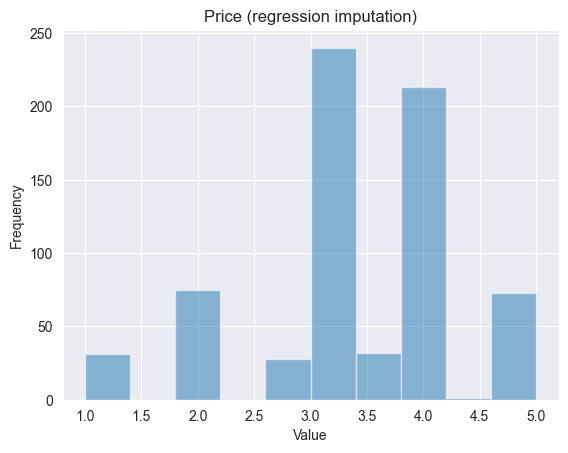

In [343]:
plt.hist(regression_datatest['price'], bins=10, alpha=0.5, label='Price')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Price (regression imputation)')
plt.show()

#### Regression imputation is resulting in a multimodal distribution, which is not suitable for our needs. Therefore, mean imputation is chosen as an alternative.

In [344]:
restaurants.isna().sum()

name         0
year         0
latitude     0
longitude    0
city         0
region       0
cuisine      0
price        0
Stars        0
dtype: int64

## VIF - preventing of multicollinearity

In [345]:
predictors_model = ['latitude', 'longitude', 'city', 'region', 'cuisine',
              'price']


df_with_constant = sm.add_constant(restaurants[predictors_model])


vif = pd.DataFrame()
vif["Variable"] = df_with_constant.columns
vif["VIF"] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

print(vif)

    Variable        VIF
0      const  30.614508
1   latitude   1.230282
2  longitude   1.492598
3       city   1.075819
4     region   1.304257
5    cuisine   1.139485
6      price   1.145224


### As we can see, none of the variables does specify the multicollinearity (1 <= VIF <= 5)

## Feature selection: Permutation importance

In [346]:
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(restaurants[predictors_model], restaurants['Stars'], test_size=0.2, random_state=42)

clf.fit(X_train, y_train)


results = permutation_importance(clf, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42)


importances = results.importances_mean


feature_names = X_test.columns


sorted_indices = np.argsort(importances)[::-1]


for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")

price: -0.025179856115107913
cuisine: -0.025899280575539585
longitude: -0.03237410071942447
city: -0.035971223021582746
region: -0.03884892086330938
latitude: -0.05395683453237412


### 'longitude', 'cuisine' and 'price' are the most influential factors in context of Michelin stars attaining

In [347]:
important_predictors = ['longitude', 'cuisine', 'price']

## SMOTE resampling technique

In [348]:
smote = SMOTE(random_state=40)
X_resampled, y_resampled = smote.fit_resample(restaurants[important_predictors], restaurants['Stars'])

## Modelling: Multinomial logistic regression, Support vector machine

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=35)

logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg_model.fit(X_train, y_train)

logreg_predictions = logreg_model.predict(X_test)

print(accuracy_score(y_test, logreg_predictions))
print(classification_report(y_test, logreg_predictions))

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

print(accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

0.5531914893617021
              precision    recall  f1-score   support

           1       0.62      0.68      0.65       117
           2       0.47      0.25      0.32       110
           3       0.53      0.74      0.62       102

    accuracy                           0.55       329
   macro avg       0.54      0.55      0.53       329
weighted avg       0.54      0.55      0.53       329

0.5349544072948328
              precision    recall  f1-score   support

           1       0.62      0.62      0.62       117
           2       0.49      0.18      0.26       110
           3       0.49      0.82      0.62       102

    accuracy                           0.53       329
   macro avg       0.53      0.54      0.50       329
weighted avg       0.53      0.53      0.50       329



## We were interested in accuracy: correctly predicted observations / all observations.
### Multinomial LogReg is showing the best performance from 2 models.
#### Remark: SVM showed the best performance with including all variables in models without feature selection

In [350]:
# Returning to initial category names, to understand mapping
decoded_city = [city_mapping[code] for code in restaurants['city']]
decoded_region = [region_mapping[code] for code in restaurants['region']]
decoded_cuisine = [cuisine_mapping[code] for code in restaurants['cuisine']]


## New observations example:
### Prediction of stars amount, provided by 2 models

In [351]:
observation_restaurant = np.array([16.315694,14 ,4]).reshape(1, -1)
observation_restaurant_2 = np.array([16.315694,14 ,2]).reshape(1, -1)

print("LogReg Prediction: ", logreg_model.predict(observation_restaurant))
print("SVM Prediction: ", svm_model.predict(observation_restaurant))

print("LogReg Prediction: ", logreg_model.predict(observation_restaurant_2))
print("SVM Prediction: ", svm_model.predict(observation_restaurant_2))

LogReg Prediction:  [3]
SVM Prediction:  [3]
LogReg Prediction:  [1]
SVM Prediction:  [1]


## Results of new predictions:

As we can see, in the case of the first observation with price - &#36;&#36;&#36;&#36; the amount of stars attained is 3 for both models. Predictions for the second observation with price - &#36;&#36; yield 1 star for both models.

